In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from torchvision import datasets, transforms, models
from torchvision.utils import save_image
import torchvision
import sys, os

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from glob import glob
import imageio


In [2]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,),
                             std=(0.5,))
    ]
)

train_dataset =  torchvision.datasets.MNIST(
    root='.',
    train=True,
    transform=transform,
    download=True
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 493kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.07MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.40MB/s]


In [3]:
len(train_dataset)

60000

In [4]:
batch_size = 128

In [7]:
data_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)


Disciminator = nn.Sequential(
    nn.Linear(784, 512),
    nn.LeakyReLU(0.2),
    nn.Linear(512, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256,1)
)

latent_dim = 100
Generator = nn.Sequential(
    nn.Linear(latent_dim, 256),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(256, momentum=0.7),
    nn.Linear(256, 512),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(512, momentum=0.7),
    nn.Linear(512, 1024),
    nn.BatchNorm1d(1024, momentum=0.7),
    nn.Linear(1024, 784),
    nn.Tanh()
)


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
D = Disciminator.to(device)
G = Generator.to(device)


In [10]:
criterion = nn.BCEWithLogitsLoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

def scale_back_image(img):
  out = (img + 1) / 2
  return out

if not os.path.exists('gan_images'):
  os.makedirs('gan_images')


In [12]:
ones_ = torch.ones(batch_size, 1).to(device)
zeros_ = torch.zeros(batch_size, 1).to(device)
d_losses = []
g_losses = []

for epoch in range(200):
  for inputs, _ in data_loader:

    n = inputs.size(0)
    inputs = inputs.reshape(n, 784).to(device)

    ones = ones_[:n]
    zeros = zeros_[:n]

    # Real Images for discriminator
    real_outputs = D(inputs)
    d_loss_real = criterion(real_outputs, ones)

    # fake images for discriminator

    noise = torch.randn(n, latent_dim).to(device)

    fake_images = G(noise)
    fake_outputs = D(fake_images)
    d_loss_fake = criterion(fake_outputs, zeros)

    # Gradient descent dor discriminator
    d_loss = 0.5 * (d_loss_real + d_loss_fake)
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()

    for _ in range(2):

      #fake images

      noise = torch.randn(n, latent_dim).to(device)

      fake_images = G(noise)
      fake_outputs = D(fake_images)

      # reverse the labels
      g_loss = criterion(fake_outputs, ones)

      d_optimizer.zero_grad()
      g_optimizer.zero_grad()

      g_loss.backward()
      g_optimizer.step()

    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())


  print(f"Epoch: {epoch}, d_loss: {d_loss.item()}, g_loss: {g_loss.item()}")

  # Save images to see evolution
  fake_images = fake_images.reshape(-1, 1, 28, 28)
  save_image(scale_back_image(fake_images), f"gan_images/{epoch+1}.png")






Epoch: 0, d_loss: 0.6915241479873657, g_loss: 0.6779879331588745
Epoch: 1, d_loss: 0.6861929893493652, g_loss: 0.7082304954528809
Epoch: 2, d_loss: 0.6816049814224243, g_loss: 0.7008579969406128
Epoch: 3, d_loss: 0.6846444010734558, g_loss: 0.709456205368042
Epoch: 4, d_loss: 0.6886115074157715, g_loss: 0.7105798721313477
Epoch: 5, d_loss: 0.6774710416793823, g_loss: 0.725533127784729
Epoch: 6, d_loss: 0.6763845682144165, g_loss: 0.7272450923919678
Epoch: 7, d_loss: 0.6706504821777344, g_loss: 0.7455910444259644
Epoch: 8, d_loss: 0.6797082424163818, g_loss: 0.6957262754440308
Epoch: 9, d_loss: 0.6801855564117432, g_loss: 0.7022053599357605
Epoch: 10, d_loss: 0.6849909424781799, g_loss: 0.7223100662231445
Epoch: 11, d_loss: 0.6694390773773193, g_loss: 0.7867223620414734
Epoch: 12, d_loss: 0.6786050796508789, g_loss: 0.7935263514518738
Epoch: 13, d_loss: 0.6753982305526733, g_loss: 0.6793686747550964
Epoch: 14, d_loss: 0.657177746295929, g_loss: 0.7634191513061523
Epoch: 15, d_loss: 0.65

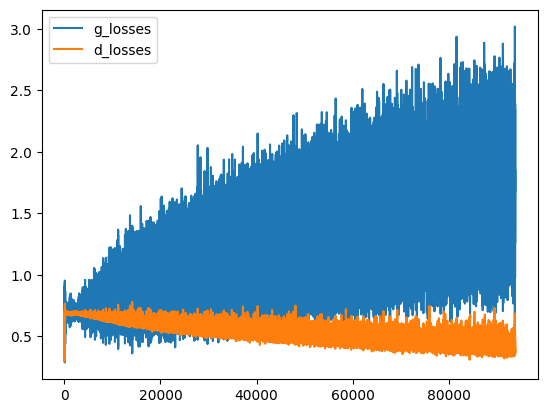

In [16]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

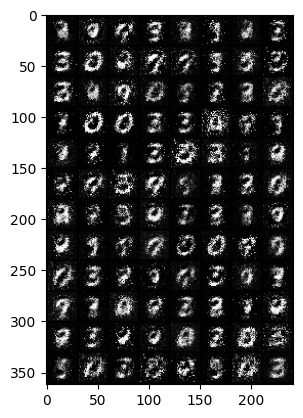

In [17]:
from skimage.io import imread

a = imread('gan_images/1.png')

plt.imshow(a)

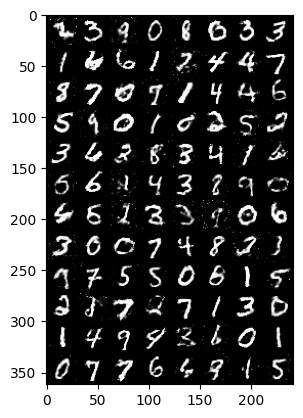

In [18]:
a = imread('gan_images/50.png')

plt.imshow(a)

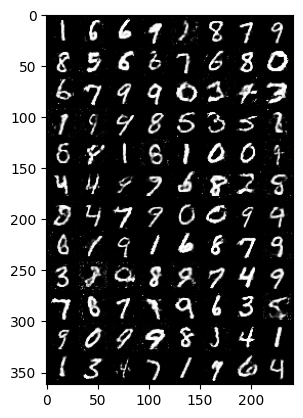

In [19]:
a = imread('gan_images/100.png')

plt.imshow(a)

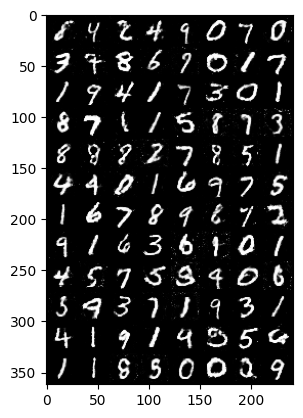

In [20]:
a = imread('gan_images/150.png')

plt.imshow(a)


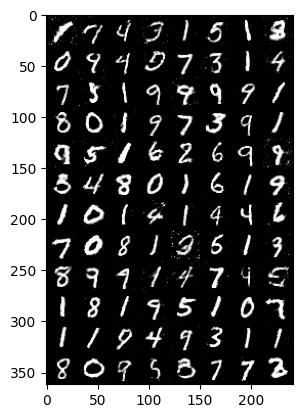

In [21]:
a = imread('gan_images/199.png')

plt.imshow(a)

NameError: name 'VGGFeatures' is not defined

NameError: name 'Ntrain' is not defined

NameError: name 'vgg_food' is not defined

NameError: name 'model' is not defined